In [5]:
# Load necessary library
import os
import pandas as pd
import numpy as np
import math
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
import seaborn as sns
import folium
import branca.colormap as cm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,8)

In [6]:
# Load and preview data 
accident = pd.read_csv("US_Accidents_June20.csv")


In [7]:
# Exclude unnecessary columns
exclude = ["TMC","End_Lat","End_Lng","Description","Number","Street","Timezone",
           "Airport_Code","Weather_Timestamp","Civil_Twilight","Nautical_Twilight","Astronomical_Twilight"]
accident_clean = accident.drop(exclude,axis=1)


In [8]:
# Adding calculation of time difference of start and end time in minutes
accident_clean.Start_Time = pd.to_datetime(accident_clean.Start_Time)
accident_clean.End_Time = pd.to_datetime(accident_clean.End_Time)
accident_clean["Time_Diff"] = (accident_clean.End_Time - accident_clean.Start_Time).astype('timedelta64[m]')

accident_clean["Start_Date"] = accident_clean["Start_Time"].dt.date
accident_clean["End_Date"] = accident_clean["End_Time"].dt.date
accident_clean["Year"] = accident_clean["Start_Time"].dt.year
accident_clean["Month"] = accident_clean["Start_Time"].dt.month
accident_clean["Day"] = accident_clean["Start_Time"].dt.day
accident_clean["Hour"] = accident_clean["Start_Time"].dt.hour

# Excluding accidents in 2015 and 2021 where there's not enough data
accident_clean = accident_clean[(accident_clean["Year"] > 2015) & (accident_clean["Year"] < 2021)]
group = accident_clean.groupby(["Year"]).agg(Count = ('ID','count'))

# Verify data
accident_clean.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Side,City,...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Time_Diff,Start_Date,End_Date,Year,Month,Day,Hour
0,A-1,MapQuest,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,R,Dayton,...,False,False,Night,314.0,2016-02-08,2016-02-08,2016,2,8,5
1,A-2,MapQuest,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,L,Reynoldsburg,...,False,False,Night,30.0,2016-02-08,2016-02-08,2016,2,8,6
2,A-3,MapQuest,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,R,Williamsburg,...,True,False,Night,30.0,2016-02-08,2016-02-08,2016,2,8,6
3,A-4,MapQuest,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.01,R,Dayton,...,False,False,Night,30.0,2016-02-08,2016-02-08,2016,2,8,7
4,A-5,MapQuest,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.01,R,Dayton,...,True,False,Day,30.0,2016-02-08,2016-02-08,2016,2,8,7


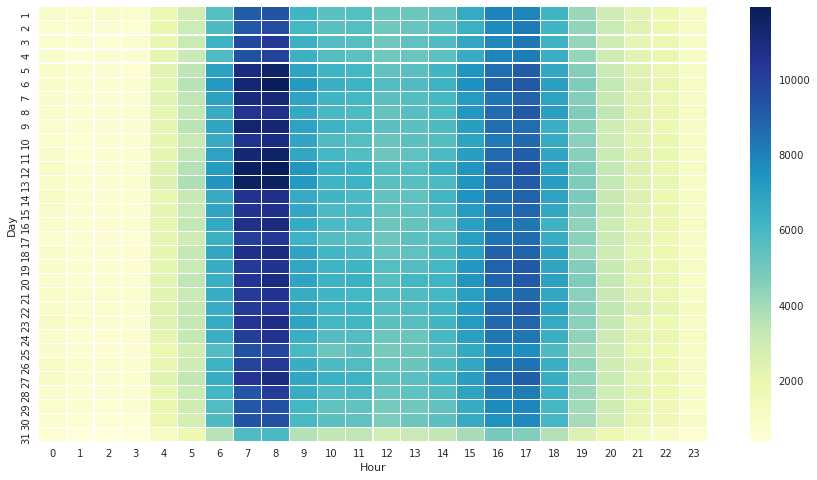

In [9]:
# Most accidents happened between 7 and 8, which is the morning rush hour
# morning rush hour have much more accidents then the afternoon rush hour, which is 4 to 6 in the afternoon

group_hour = accident_clean.groupby(["Day","Hour"]).size().unstack()
ax = sns.heatmap(group_hour, cmap="YlGnBu",linewidths=0.1)

In [11]:
variable = ["Severity","Distance(mi)","Time_Diff","Temperature(F)","Wind_Chill(F)","Humidity(%)",
           "Pressure(in)","Visibility(mi)","Wind_Speed(mph)","Precipitation(in)"]
accident_model = accident_clean[variable]
accident_model = accident_model.dropna()
# accident_model['Severity'] = np.where(accident_model['Severity']<=2, 0, 1)
accident_model.head()

,Severity,Distance(mi),Time_Diff,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
5,3,0.01,30.0,37.9,35.5,97.0,29.63,7.0,3.5,0.03
9,3,0.01,30.0,37.4,33.8,100.0,29.62,3.0,4.6,0.02
11,3,0.01,30.0,37.4,33.8,100.0,29.62,3.0,4.6,0.02
14,2,0.01,30.0,37.4,33.8,100.0,29.62,3.0,4.6,0.02
20,2,0.00,30.0,33.8,29.6,100.0,29.62,2.0,4.6,0.01


In [12]:
Y = accident_model.loc[:,'Severity'].values
X = accident_model.loc[:,'Distance(mi)':'Precipitation(in)'].values

standardized_X = preprocessing.scale(X)
train_x, test_x, train_y, test_y = train_test_split(standardized_X,Y , test_size=0.3, random_state=0)

model = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000)
model.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
model.score(test_x, test_y)

0.7143793143793143

Text(315.06, 0.5, 'true value')

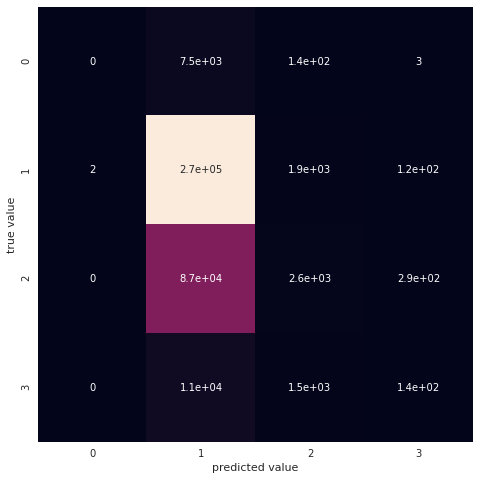

In [14]:
model_y = model.predict(test_x)

mat = confusion_matrix(test_y,model_y)
sns.heatmap(mat, square=True, annot=True, cbar=False) 
plt.xlabel('predicted value')
plt.ylabel('true value')